In [1]:
datasetdir = 'C:\\Users\\reekithak\\Audio_Models\\Data\\Images'
import os
os.chdir(datasetdir)

import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32
def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        #horizontal_flip = True, 
        validation_split = 0.25,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('bad','good'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('bad','good'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset

In [3]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [4]:
vgg19 = keras.applications.vgg19
conv_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers: 
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
train_dataset, val_dataset = generators((224,224), preprocessing=vgg19.preprocess_input)

Found 1662 images belonging to 2 classes.
Found 554 images belonging to 2 classes.


In [6]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
EARLY_STOP_PATIENCE = 3
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'C:\\Users\\reekithak\\Audio_Models\\4.vgg19\\new_vgg19.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [7]:
full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['accuracy'])
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=10,
    callbacks=[cb_checkpointer, cb_early_stopper]
)
full_model.load_weights('C:\\Users\\reekithak\\Audio_Models\\4.vgg19\\new_vgg19.hdf5')

c:\users\reekithak\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
52/52 [==============================] - 487s 9s/step - loss: 2.3767 - accuracy: 0.7134 - val_loss: 0.1549 - val_accuracy: 0.9477
Epoch 2/10
52/52 [==============================] - 478s 9s/step - loss: 0.0472 - accuracy: 0.9864 - val_loss: 0.2166 - val_accuracy: 0.9260
Epoch 3/10
52/52 [==============================] - 484s 9s/step - loss: 0.0186 - accuracy: 0.9939 - val_loss: 0.2358 - val_accuracy: 0.9224
Epoch 4/10
52/52 [==============================] - 483s 9s/step - loss: 0.0055 - accuracy: 0.9996 - val_loss: 0.2548 - val_accuracy: 0.9188


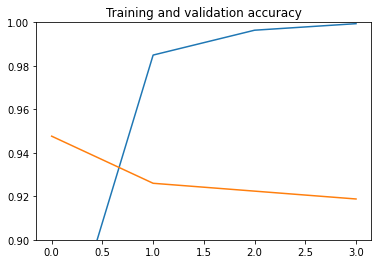

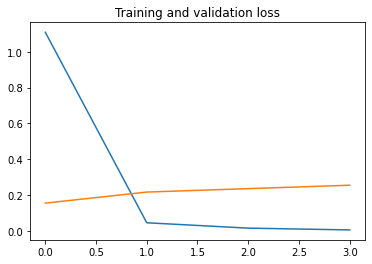

In [8]:
plot_history(history, yrange=(0.9,1))

**Prediction**

In [9]:
full_model.save('new_vgg19.h5')